In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


<ipython-input-2-8e3ff49944cd>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="style", y="ave_max_dep", data=df, palette="Set2")


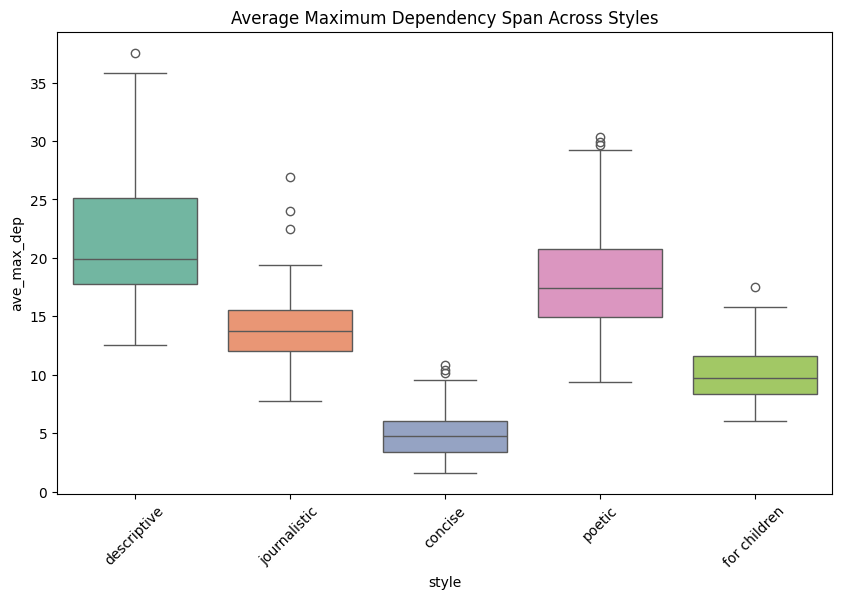

In [2]:
import json
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


# Loading our dataset file- stories.json
with open('stories.json', 'r') as f:
    data = json.load(f)
    stories = data["stories"]

# Loading spacy model
nlp = spacy.load("en_core_web_sm")

#Calculating longest dependency span
def dependency_span(sentence):
    doc = nlp(sentence)
    spans = [abs(token.head.i - token.i) for token in doc if token.head != token]
    return max(spans, default=0)

# Analyze dependency spans
story_stats = []
for story in stories:
    sentences = story["story"].split(". ")  # Basic sentence splitting
    max_dep = [dependency_span(sent) for sent in sentences]
    ave_max_dep = sum(max_dep) / len(max_dep) if max_dep else 0
    story_stats.append({
        "index": story["index"],
        "style": story["style"],
        "outcome": story["outcome"],
        "ave_max_dep": ave_max_dep
    })

# Convert to DataFrame
df = pd.DataFrame(story_stats)

# Visualize dependency span across styles
plt.figure(figsize=(10, 6))
sns.boxplot(x="style", y="ave_max_dep", data=df, palette="Set2")
plt.title("Average Maximum Dependency Span Across Styles")
plt.xticks(rotation=45)
plt.show()


import plotly.express as px
import pandas as pd

# Data (already in 'df' in your case)
fig = px.violin(df, y="ave_max_dep", x="style", box=True, points="all",
                title="Raincloud Plot: Average Maximum Dependency Span Across Styles",
                color="style", color_discrete_sequence=px.colors.qualitative.Set2)

fig.show()



<Figure size 1200x600 with 0 Axes>

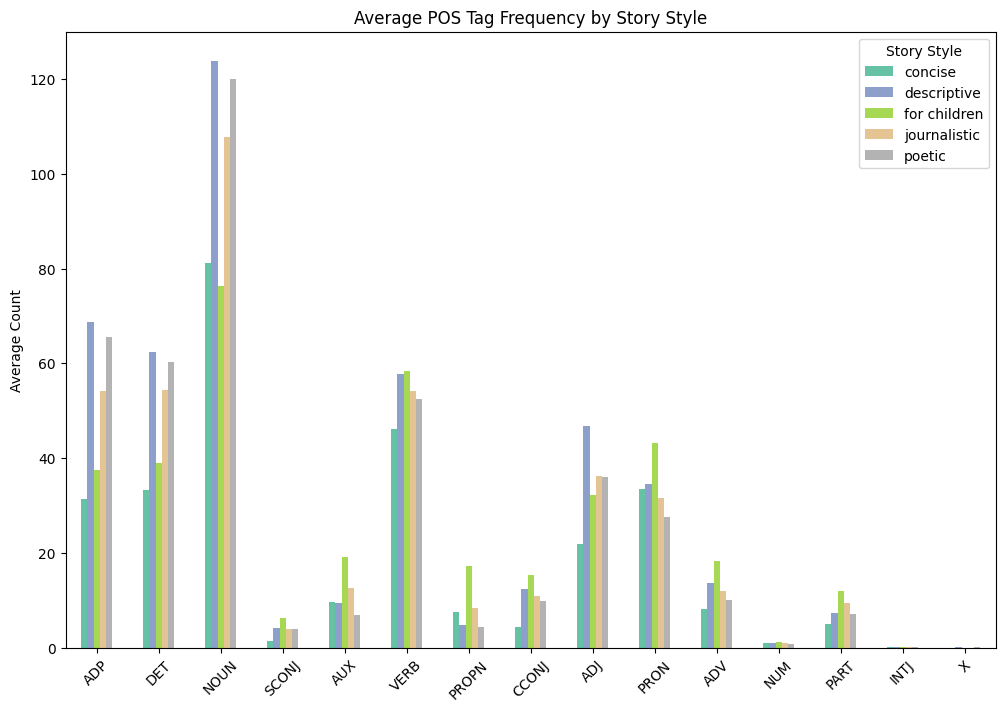


T-test results for POS tag differences between Victory and Defeat:
         t_stat   p_value
PROPN  2.031564  0.042659
ADV    1.245721  0.213358
VERB   0.777714  0.437044
NOUN   0.654611  0.512971
ADJ   -0.083359  0.933594


<ipython-input-3-0f79e9edfe93>:76: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




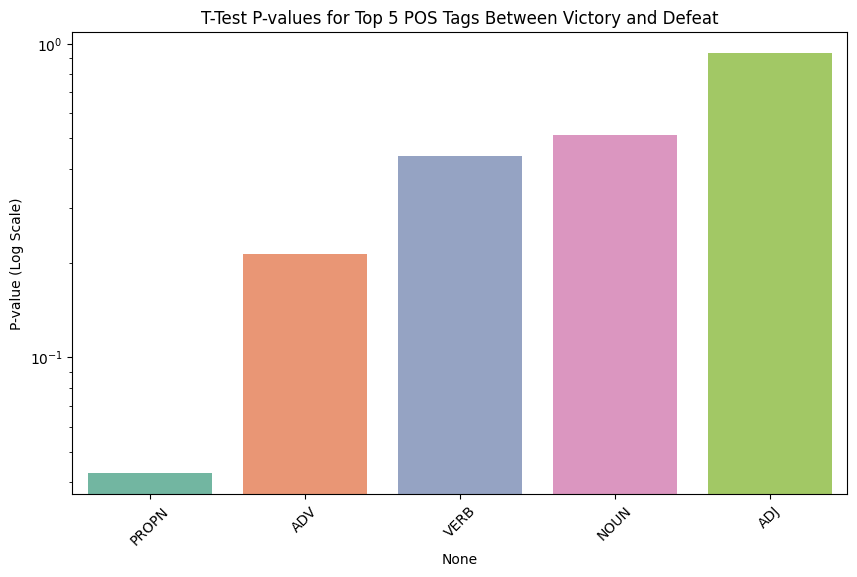

In [3]:


# Function to count POS tags in a sentence
def pos_tagging(sentence):
    doc = nlp(sentence)
    pos_counts = {}
    for token in doc:
        pos = token.pos_
        pos_counts[pos] = pos_counts.get(pos, 0) + 1
    return pos_counts

# Analyze POS tags in the stories
pos_stats = []
for story in stories:
    sentences = story["story"].split(". ")  # Basic sentence splitting
    total_pos_count = {}  # Dictionary to store aggregated POS counts per story

    for sentence in sentences:
        sentence_pos_counts = pos_tagging(sentence)
        for pos, count in sentence_pos_counts.items():
            total_pos_count[pos] = total_pos_count.get(pos, 0) + count  # Aggregate POS counts

    # Append the dictionary to the list
    story_entry = {
        "index": story["index"],
        "style": story["style"],
        "outcome": story["outcome"]

    }
    story_entry.update(total_pos_count)  # Merge POS counts into the dictionary
    pos_stats.append(story_entry)

# Convert to DataFrame
df_pos = pd.DataFrame(pos_stats).fillna(0)  # Replace NaN values with 0

# Get the list of POS tags dynamically, excluding irrelevant ones
irrelevant_tags = {"PUNCT", "SPACE", "SYM"}
pos_columns = [col for col in df_pos.columns if col not in ["index", "style", "outcome"] and col not in irrelevant_tags]

# Group by story style and calculate average POS counts
df_pos_style = df_pos.groupby("style")[pos_columns].mean()


# Visualize the average POS counts by story style
plt.figure(figsize=(12, 6))
df_pos_style.T.plot(kind="bar", figsize=(12, 8), colormap="Set2")
plt.title("Average POS Tag Frequency by Story Style")
plt.ylabel("Average Count")
plt.xticks(rotation=45)
plt.legend(title="Story Style")
plt.show()


# Identify the top 5 most frequent POS tags across all stories
#top_tags = df_pos[pos_columns].sum().sort_values(ascending=False).head(5).index.tolist()

top_tags = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']

# Perform t-tests for each of the top tags between "victory" and "defeat" outcomes
victory_pos = df_pos[df_pos["outcome"] == "victory"][top_tags]
defeat_pos = df_pos[df_pos["outcome"] == "defeat"][top_tags]

# Apply t-test for each POS tag
t_test_results = {}
for tag in top_tags:
    t_stat, p_value = ttest_ind(victory_pos[tag], defeat_pos[tag], equal_var=False)
    t_test_results[tag] = {"t_stat": t_stat, "p_value": p_value}

# Convert results to DataFrame
t_test_results_df = pd.DataFrame(t_test_results).T.sort_values(by="p_value")

# Display results
print("\nT-test results for POS tag differences between Victory and Defeat:")
print(t_test_results_df)

# Visualize t-test results (p-values)
plt.figure(figsize=(10, 6))
sns.barplot(x=t_test_results_df.index, y=t_test_results_df["p_value"], palette="Set2")
plt.yscale("log")  # Log scale for better visualization
plt.title("T-Test P-values for Top 5 POS Tags Between Victory and Defeat")
plt.ylabel("P-value (Log Scale)")
plt.xticks(rotation=45)
plt.show()
